# Associate ripples/spindle and Ca2+ signal from multiple Minian files
SHORT and focus on PFC
-> in contrary to 14/14bis, here we center on SWR and not spindles and we ask whether SWR are associated with change in cortical dynamics

In [26]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

In [27]:
folder = Path('Gaelle/Baseline_recording/ThreeColDots/')
session = 3
subsession = 4
numbsubsession = 5

folder_base = folder / f'session{session}/'
folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/session{session}{subsession}/minian/'

filenameE = folder_Ephys / f'SWRproperties.csv'
SWRprop = pd.read_csv(filenameE)
filenameE = folder_Ephys / f'Spindleproperties_PFC.csv'
PFCspiprop = pd.read_csv(filenameE)

filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)

dict_minian = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base / f'V4_Miniscope/session{session}{x}/minian'
    dict_minian["ds_minian{0}".format(x)] = open_minian(folder_MinisSess)


for file_path in folder_base.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

#TodropFile = folder_Minis / f'TokeepFile.json'
#with open(TodropFile, 'r') as f:
#    unit_to_keep = json.load(f)

TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepL = [e for e in All_units if e not in unit_to_drop]
#UnitToKeepL = [e for e in All_units if e in unit_to_keep]
#unit_to_drop = [e for e in All_units if e not in unit_to_keep]
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(len(UnitToKeepL))
print(len(unit_to_drop))
print(len(All_units))

8
119
127


In [28]:

# start time
StartTime1 = (list(stamps[0])[0])

# start time session 2
def Convert(string):
    li = list(string.split(", "))
    li2 = len(li)
    return li2
stri = stamps[0][3]

numbdropfr = Convert(stri)


from ast import literal_eval
list_droppedframes = literal_eval(stamps[0][3])


dict_StartTime = {}
dict_StartTime[1] = (list(stamps[0])[0])
dict_EndTime = {}
dict_RecDur = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base / f'V4_Miniscope/session{session}{x}/minian'
    minian_ds = open_minian(folder_MinisSess)
    C = minian_ds['C']
    dict_RecDur[x] = C.shape[1]
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(numbdropfr) if list_droppedframes[item] < dict_RecDur[x]))
    else:
        numbdropfr = 0
    dict_EndTime[x] = dict_StartTime[x] + (dict_RecDur[x] + numbdropfr)/stamps[0][2]
    if x < numbsubsession:
        dict_StartTime[x+1] = dict_EndTime[x]

print(dict_StartTime)
print(dict_EndTime)
print(dict_RecDur)

{1: 2.67248, 2: 836.0058133333333, 3: 1702.67248, 4: 2536.005813333333, 5: 3369.3391466666667}
{1: 836.0058133333333, 2: 1702.67248, 3: 2536.005813333333, 4: 3369.3391466666667, 5: 4407.339146666667}
{1: 25000, 2: 26000, 3: 25000, 4: 25000, 5: 31140}


In [29]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return len(myList)
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def take_closest2(myList, myNumber):
    value2 = 10000000
    for ind in range(len(myList)):
        value = abs(myList[ind]-myNumber)
        if value < value2:
            value2 = value
            index = myList[ind]
    return index


def take_closest3(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        dummy = myList.index(after)
        return dummy
    else:
        dummy = myList.index(before)
        return dummy

In [30]:
StartTime = dict_StartTime[subsession]
EndTime = dict_EndTime[subsession]
rec_dur = dict_RecDur[subsession]
minian_ds = dict_minian[f"ds_minian{subsession}"]


PFCspiprop[["peak time", "start time", "end time"]] = PFCspiprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)
SWRprop[["peak time", "start time", "end time"]] = SWRprop[["peak time", "start time", "end time"]]-(list(stamps[0])[0]*1000)

C = minian_ds['C']
A = minian_ds['A']
B = A['unit_id']
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C = C.loc[unit_to_keep,:]
nb_unit = C.shape[0]
rec_dur = C.shape[1]

StartTimeIndexSpi = take_closest3(list(PFCspiprop["start time"]), StartTime*1000)
EndTimeIndexSpi = take_closest3(list(PFCspiprop["start time"]), EndTime*1000)

if StartTimeIndexSpi > len(list(PFCspiprop["start time"])):
    StartTimeIndexSpi = 0
if EndTimeIndexSpi > len(list(PFCspiprop["start time"])):
    EndTimeIndexSpi = len(list(PFCspiprop["start time"]))

PFCspiprop = PFCspiprop[StartTimeIndexSpi:EndTimeIndexSpi]

StartTimeIndexSWR = take_closest3(list(SWRprop["start time"]), StartTime*1000)
EndTimeIndexSWR = take_closest3(list(SWRprop["start time"]), EndTime*1000)
if StartTimeIndexSWR > len(list(SWRprop["start time"])):
    StartTimeIndexSWR = 0
if EndTimeIndexSWR > len(list(SWRprop["start time"])):
    EndTimeIndexSWR = len(list(SWRprop["start time"]))

SWRprop = SWRprop[StartTimeIndexSWR:EndTimeIndexSWR]


In [31]:
Struct = "PFC"
after = 1000 # ms
counterNegSWR = 0
counterWinSWR = 0
counterUncSWR = 0
SWRinSpindle = list()
NegCoupled_SWR = list()
unCoupled_SWR = list()

serSpi = pd.Series(PFCspiprop["start time"]).to_list()
endSpi = pd.Series(PFCspiprop["end time"]).to_list()
serSWR = pd.Series(SWRprop["end time"]).to_list()
nb_SWR = SWRprop.shape[0]
nb_Spindle = PFCspiprop.shape[0]
for Pswr in range(nb_SWR):
    Closest_Spindle = take_closest2(serSpi, serSWR[Pswr])
    index = int(take_closest3(serSpi, serSWR[Pswr]))
    if index > nb_Spindle:
        index = 0
    elif index < 0:
        index = 0
    SpinDur = endSpi[index] - serSpi[index]
    distance = serSWR[Pswr] - Closest_Spindle 
#    print(Closest_Spindle, serSWR[Pswr], distance, SpinDur, index)
    if (distance < (SpinDur)) and (distance >  0): # SWR in Spindle
        counterWinSWR = counterWinSWR + 1
        SWRinSpindle.append(Pswr)
        #print("in", serSpi[index], serSWR[Pswr], distance, SpinDur)
    elif (distance < (0)) and (distance > (-after)): # SWR preceeds Spindle
        counterNegSWR = counterNegSWR + 1
        NegCoupled_SWR.append(Pswr)
        #print("pre", serSpi[index], serSWR[Pswr], distance)
    else:
        unCoupled_SWR.append(Pswr)
        counterUncSWR = counterUncSWR + 1

print(counterNegSWR, counterWinSWR, counterUncSWR)
#print(len(PreCoupled_spindlesPFC)/nb_spindle)
#print(len(PostCoupled_spindlesPFC)/nb_spindle)

23 19 552


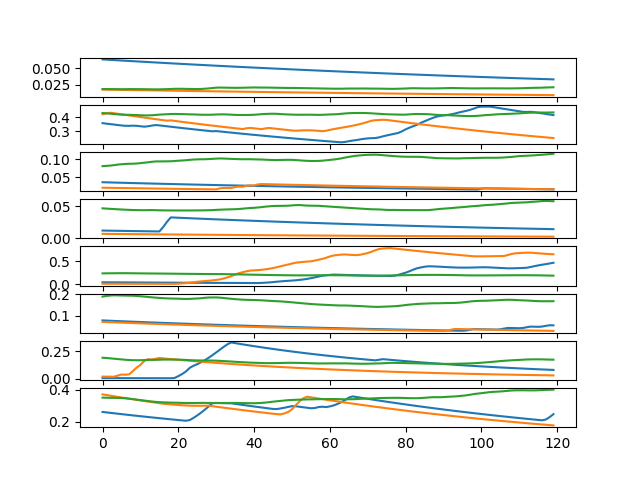

In [32]:
#C.isel(unit_id=0).values
Cseries = C.to_series()
units = range(len(UnitToKeepInd))
maxi = len(UnitToKeepInd)
duration = 2
threshold = 1

#ActivityCa_PFCspin = pd.Series(np.zeros(duration*2*Acq_freq))
ActivityCa_SWR = pd.Series(np.zeros(duration*2*Acq_freq))
time = range(duration*2*Acq_freq)
Half = int(ActivityCa_SWR.shape[0]/2)
TimeStamps_miniscope = list(stamps_miniscope["Time Stamp (ms)"] + (StartTime*1000))
plt.close()

fig, axs = plt.subplots(nrows=maxi, ncols=1)


AVGActivityCa_negSWR = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_negSWR = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in units:
    ActivityCa_negSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    AVGlocActivityCa_negSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = C.isel(unit_id=unit).values
    for Pspin in NegCoupled_SWR:
        ser = list(pd.Series(SWRprop["start time"]))
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = lCseries[index-Half:index+Half]
        if len(trace)<len(time):
            print("pre, unit = ", unit, "SWR = ", Pspin)
        else:
            ActivityCa_negSWR = ActivityCa_negSWR+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_negSWR)>(len(NegCoupled_SWR)*threshold):
        nActivityCa_negSWR = ActivityCa_negSWR/max(ActivityCa_negSWR)
    else:
        nActivityCa_negSWR = 0#ActivityCa_PFCspin
    
    AVGActivityCa_negSWR = AVGActivityCa_negSWR + ActivityCa_negSWR    
    AVGlocActivityCa_negSWR = AVGlocActivityCa_negSWR + ActivityCa_negSWR    
    nAVGActivityCa_negSWR = nAVGActivityCa_negSWR + nActivityCa_negSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_negSWR/counterNegSWR) 

if max(AVGActivityCa_negSWR)>(threshold):
    nAVGActivityCa_negSWR = AVGActivityCa_negSWR/max(AVGActivityCa_negSWR)
else:
    nAVGActivityCa_negSWR = AVGActivityCa_negSWR


prCactBefore = sum(AVGActivityCa_negSWR[0:Half])
prCactAfter = sum(AVGActivityCa_negSWR[Half:2*Half])
nprCactBefore = sum(nAVGActivityCa_negSWR[0:Half])
nprCactAfter = sum(nAVGActivityCa_negSWR[Half:2*Half])


AVGActivityCa_winSWR = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_winSWR = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in units:
    AVGlocActivityCa_winSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    ActivityCa_winSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in SWRinSpindle:
        ser = list(pd.Series(SWRprop["start time"]))
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        index = TimeStamps_miniscope.index(Frame_SWR_start)
        trace = list(lCseries[index-Half:index+Half])
        if len(trace)<len(time):
            print("post, unit = ", unit, "SWR = ", Pspin)
        else:
            ActivityCa_winSWR = ActivityCa_winSWR+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_winSWR)>(len(SWRinSpindle)*threshold):
        nActivityCa_winSWR = ActivityCa_winSWR/max(ActivityCa_winSWR)
    else:
        nActivityCa_winSWR = 0
    AVGActivityCa_winSWR = AVGActivityCa_winSWR + ActivityCa_winSWR
    AVGlocActivityCa_winSWR = AVGlocActivityCa_winSWR + ActivityCa_winSWR   
    nAVGActivityCa_winSWR = nAVGActivityCa_winSWR + nActivityCa_winSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_winSWR/counterWinSWR) 

if max(AVGActivityCa_winSWR)>(threshold):
    nAVGActivityCa_winSWR = AVGActivityCa_winSWR/max(AVGActivityCa_winSWR)
else:
    nAVGActivityCa_winSWR = AVGActivityCa_winSWR


poCactBefore = sum(AVGActivityCa_winSWR[0:Half])
poCactAfter = sum(AVGActivityCa_winSWR[Half:2*Half])
npoCactBefore = sum(nAVGActivityCa_winSWR[0:Half])
npoCactAfter = sum(nAVGActivityCa_winSWR[Half:2*Half])

AVGActivityCa_uncSWR = pd.Series(np.zeros(duration*2*Acq_freq))
nAVGActivityCa_uncSWR = pd.Series(np.zeros(duration*2*Acq_freq))
for unit in units:
    ActivityCa_uncSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    AVGlocActivityCa_uncSWR = pd.Series(np.zeros(duration*2*Acq_freq))
    lCseries = np.array(Cseries)[(unit)*rec_dur:(unit+1)*rec_dur]
    for Pspin in unCoupled_SWR:
        ser = list(pd.Series(SWRprop["start time"]))
        Frame_SWR_start = take_closest(TimeStamps_miniscope, ser[Pspin])
        if Frame_SWR_start > 0:
            index = TimeStamps_miniscope.index(Frame_SWR_start)
            trace = list(lCseries[index-Half:index+Half])
            if len(trace)<len(time):
                print("unc, unit = ", unit, "SWR = ", Pspin)
            else:
                ActivityCa_uncSWR = ActivityCa_uncSWR+list(lCseries[index-Half:index+Half])
    if max(ActivityCa_uncSWR)>(len(unCoupled_SWR)*threshold):
        nActivityCa_uncSWR = ActivityCa_uncSWR/max(ActivityCa_uncSWR)
    else:
        nActivityCa_uncSWR = 0#ActivityCa_PFCspin
    AVGActivityCa_uncSWR = AVGActivityCa_uncSWR + ActivityCa_uncSWR
    AVGlocActivityCa_uncSWR = AVGlocActivityCa_uncSWR + ActivityCa_uncSWR   
    nAVGActivityCa_uncSWR = nAVGActivityCa_uncSWR + nActivityCa_uncSWR 
    ax = axs[unit]
    ax.plot(time, AVGlocActivityCa_uncSWR/counterUncSWR) 

if max(AVGActivityCa_uncSWR)>(threshold):
    nAVGActivityCa_uncSWR = AVGActivityCa_uncSWR/max(AVGActivityCa_uncSWR)
else:
    nAVGActivityCa_uncSWR = AVGActivityCa_uncSWR

unCactBefore = sum(AVGActivityCa_uncSWR[0:Half])
unCactAfter = sum(AVGActivityCa_uncSWR[Half:2*Half])
nunCactBefore = sum(nAVGActivityCa_uncSWR[0:Half])
nunCactAfter = sum(nAVGActivityCa_uncSWR[Half:2*Half])
#fig.savefig('mafigure.svg')
#plt.plot(time, AVGActivityCa_negSWR/counterNegSWR, label='NegCoupling')  
#plt.plot(time, AVGActivityCa_winSWR/counterWinSWR, label='SWRinSpindle')  
#plt.plot(time, AVGActivityCa_uncSWR/counterUncSWR, label='UnCoup')

#plt.legend();
#plt.show()

In [33]:
negCoupledBef = prCactBefore
negCoupledAft = prCactAfter
nnegCoupledBef = nprCactBefore
nnegCoupledAft = nprCactAfter

posCoupledBef = poCactBefore
posCoupledAft = poCactAfter
nposCoupledBef = npoCactBefore
nposCoupledAft = npoCactAfter

unCoupledBef = unCactBefore
unCoupledAft = unCactAfter
nunCoupledBef = nunCactBefore
nunCoupledAft = nunCactAfter

outSumm = pd.Series([negCoupledBef, negCoupledAft, posCoupledBef, posCoupledAft, unCoupledBef, unCoupledAft, nnegCoupledBef, nnegCoupledAft, nposCoupledBef, nposCoupledAft, nunCoupledBef, nunCoupledAft],
              index=["NCB", "NCA", "wSCB", "wSCA", "1CB", "1CA", "nNCB", "nNCA", "nwSCB", "nwSCA", "n1CB", "n1CA"])

filenameOut = folder_base / f'Ca2+intSWRspindles_16ter.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()

filenameOut = folder_Minis / f'Ca2+intSWRspindles_16ter.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.save()
outSumm


NCB       1294.103365
NCA       1666.721983
wSCB      1208.695499
wSCA      1548.332428
1CB      48455.334166
1CA      48457.359062
nNCB        42.369335
nNCA        54.568981
nwSCB       40.194135
nwSCA       51.488470
n1CB        56.322115
n1CA        56.324469
dtype: float64